# Time Series

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math

In [ ]:
from scipy.stats import norm
def evaluate_AIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and
  the residuals of the model. Assumes residuals are distributed
  Gaussian with unknown variance.
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return 2 * k - 2 * np.sum(log_likelihood)
def evaluate_BIC(k, residuals):
  """
  Finds the AIC given the number of parameters estimated and
  the residuals of the model. Assumes residuals are distributed
  Gaussian with unknown variance.
  """
  standard_deviation = np.std(residuals)
  log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
  return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)

## The Mauna Loa CO_2 Concentration

### Preprocess data

In [ ]:
df_co2 = pd.read_csv("CO2.csv", skiprows=54, usecols=[0, 1, 4]).drop([0, 1])
df_co2['t'] = (df_co2.index + 0.5) /12

# Trim columns
trimmed_cols = {col: col.strip() for col in df_co2.columns}
df_co2.rename(columns=trimmed_cols, inplace=True)

# Convert year to int
df_co2["Yr"] = df_co2["Yr"].astype(int)

# Convert CO2 to float
df_co2["CO2"] = df_co2["CO2"].astype(np.float32)

# Remove incomplete rows
df_co2 = df_co2[df_co2.CO2 !=-99.989998]

# Reset index
df_co2 = df_co2.reset_index(drop=True)


In [ ]:
df_co2.head()

,Yr,Mn,CO2,t
0,1958,03,315.700012,0.375000
1,1958,04,317.450012,0.458333
2,1958,05,317.510010,0.541667
3,1958,07,315.859985,0.708333
4,1958,08,314.929993,0.791667


In [ ]:
df_co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Yr      734 non-null    int32  
 1   Mn      734 non-null    object 
 2   CO2     734 non-null    float32
 3   t       734 non-null    float64
dtypes: float32(1), float64(1), int32(1), object(1)
memory usage: 17.3+ KB


In [ ]:
X = df_co2[["t"]]
y = df_co2.CO2

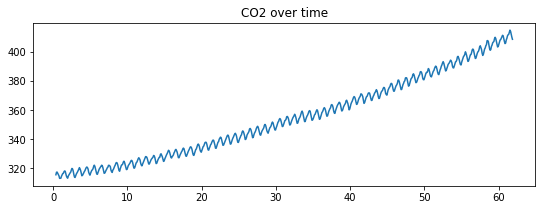

In [ ]:
fig = plt.figure(figsize=(9, 3))
plt.plot(X, y)
plt.title("CO2 over time")
plt.show()

### Split data

In [ ]:
train_test_split = math.ceil(len(y) * 0.8)
train_co2, test_co2 = y[:train_test_split], y[train_test_split:]
train_t, test_t = X[:train_test_split], X[train_test_split:]
assert(len(train_t) + len(test_t) == len(X))

In [ ]:
len(train_co2)

588

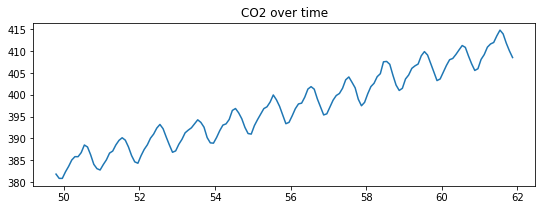

In [ ]:
fig = plt.figure(figsize=(9, 3))
plt.plot(test_t, test_co2)
plt.title("CO2 over time")
plt.show()

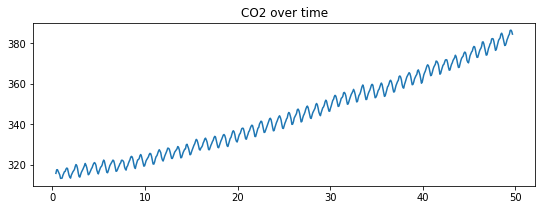

In [ ]:
fig = plt.figure(figsize=(9, 3))
plt.plot(train_t, train_co2)
plt.title("CO2 over time")
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

def fit_poly_linear_regression(x_train, y_train, x_test, y_test, degree=1):

    if degree > 1:
        # Create a PolynomialFeatures object to generate the quadratic term
        poly = PolynomialFeatures(degree=degree)

        # Transform the input features to include the quadratic term
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.fit_transform(x_test)
    else:
        x_train_poly = x_train
        x_test_poly = x_test

    # Create a LinearRegression object and fit the model
    lr = LinearRegression()
    lr.fit(x_train_poly, y_train)

    print(f"Intercept (B0): {lr.intercept_}")
    if degree > 1:
        for i in range(1, len(lr.coef_)):
            print(f"Weight (B{i}): {lr.coef_[i]}")
    else:
        print(f"Weight (B1): {lr.coef_[0]}")

    prediction = lr.predict(x_test_poly)
    print("RMSE: {}".format(mean_squared_error(y_test, prediction, squared=False)))
    print("MAPE: {}".format(mean_absolute_percentage_error(y_test, prediction)*100))

    fig = plt.figure(figsize=(9, 3))
    plt.plot(x_test, y_test, label='y over time (original data)')
    plt.plot(x_test, prediction, 'r', label='fitted line')
    plt.legend()
    plt.title("Test set")
    plt.show()

    prediction_train = lr.predict(x_train_poly)
    fig = plt.figure(figsize=(9, 3))
    plt.plot(x_train, y_train, label='y over time (original data)')
    plt.plot(x_train, prediction_train, 'r', label='fitted line')
    plt.legend()
    plt.title("Train set")
    plt.show()

    linear_residuals = y_train - prediction_train
    plt.plot(x_train, linear_residuals, 'o')
    plt.title("Residuals over time train set")
    plt.show();
    print("AIC:", evaluate_AIC(degree, linear_residuals))
    print("BIC:", evaluate_BIC(degree, linear_residuals))

    return lr, linear_residuals

### Fit linear regression

Intercept (B0): 308.73697430241816
Weight (B1): 1.407881791556056
RMSE: 10.62321297935594
MAPE: 2.445351449000107


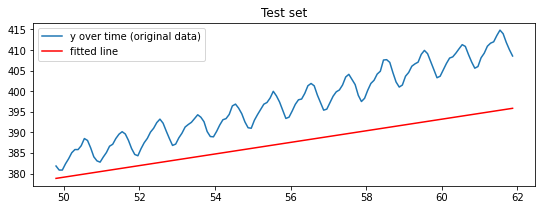

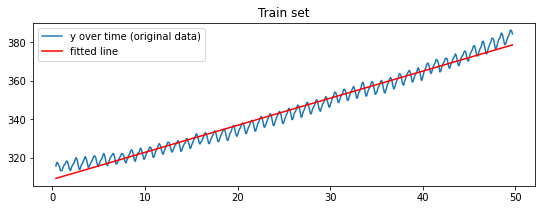

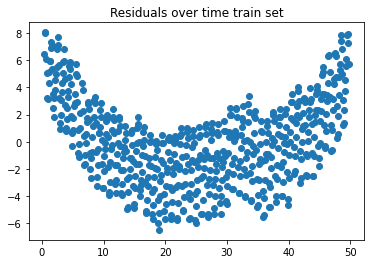

AIC: 3001.1582886403285
BIC: 3005.535015588227


In [ ]:
_, _ = fit_poly_linear_regression(train_t, train_co2, test_t, test_co2, 1)

### Fit quadratic linear regression

Intercept (B0): 313.9719473224313
Weight (B1): 0.7973338093602704
Weight (B2): 0.012135429772483625
RMSE: 2.5018943915296408
MAPE: 0.5327130356940849


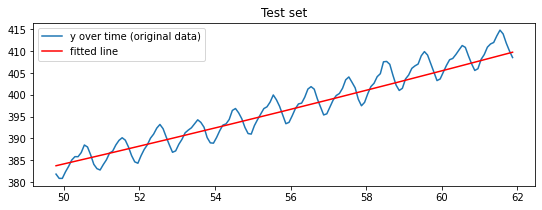

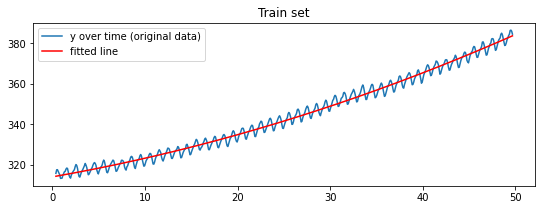

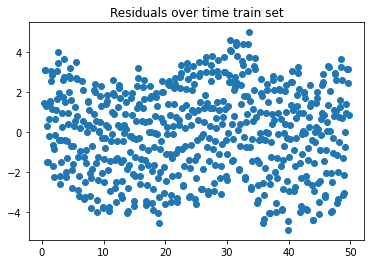

AIC: 2592.6799938793492
BIC: 2601.4334477751463


In [ ]:
quadratic_model, quadratic_residuals = fit_poly_linear_regression(train_t, train_co2, test_t, test_co2, 2)

### Fit cubic linear regression

Intercept (B0): 314.7429542797092
Weight (B1): 0.6212824225733432
Weight (B2): 0.020817445822014065
Weight (B3): -0.00011524350476903898
RMSE: 4.078414578023163
MAPE: 0.8342515040581165


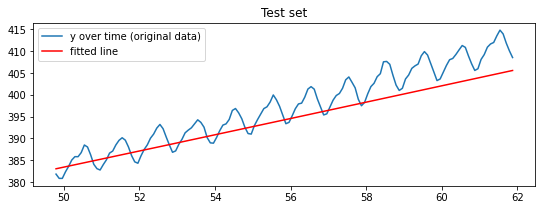

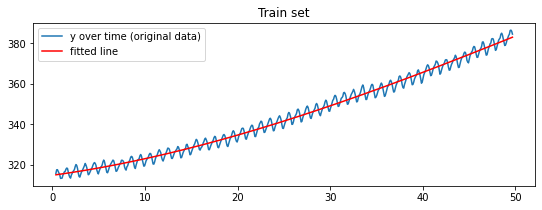

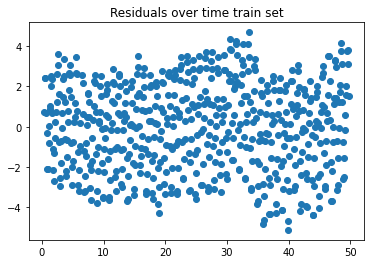

AIC: 2586.218490653641
BIC: 2599.348671497337


In [ ]:
_, _ = fit_poly_linear_regression(train_t, train_co2, test_t, test_co2, 3)

### Periodic Signal

In [ ]:
# Values without quadratic trending (train dataset)
type(quadratic_residuals)
# quadratic_model

pandas.core.series.Series

In [ ]:
dataset = df_co2[:train_test_split]
dataset["CO2_dtrend"] = quadratic_residuals

C:\Users\LuisGonzalez\AppData\Local\Temp\ipykernel_34056\3180738865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["CO2_dtrend"] = quadratic_residuals


In [ ]:
print(min(dataset.Yr))
print(max(dataset.Yr))
dataset.head()

1958
2007


,Yr,Mn,CO2,t,CO2_dtrend
0,1958,03,315.700012,0.375000,1.427358
1,1958,04,317.450012,0.458333,3.110071
2,1958,05,317.510010,0.541667,3.102613
3,1958,07,315.859985,0.708333,1.317171
4,1958,08,314.929993,0.791667,0.319217


In [ ]:
grouped = dataset.groupby('Mn')['CO2_dtrend'].mean().reset_index()
grouped.rename(columns={"CO2_dtrend": "CO2_dtrend_avg"}, inplace=True)
grouped

,Mn,CO2_dtrend_avg
0,01,-0.014358
1,02,0.644942
2,03,1.354029
3,04,2.560303
4,05,2.981335
5,06,2.314957
6,07,0.776412
7,08,-1.302578
8,09,-3.129452
9,10,-3.310862


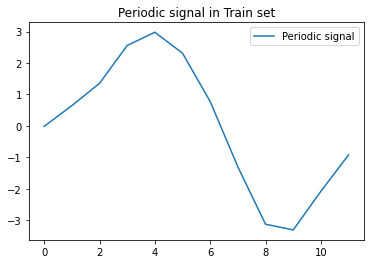

In [ ]:
# plt.figure(figsize=(9, 3))
plt.plot(grouped.CO2_dtrend_avg, label='Periodic signal')
plt.legend()
plt.title("Periodic signal in Train set")
plt.show()

In [ ]:
#dataset["CO2_pred"] = dataset["CO2"] - quadratic_residuals
#dataset.head()

In [ ]:
max(train_t.t)

49.708333333333336

In [ ]:
all_dataset = df_co2.copy()
# Classify in train and test
all_dataset["type"] = np.where(all_dataset["t"] > max(train_t.t), "test", "train")

# Run predictions
# Create a PolynomialFeatures object to generate the quadratic term
poly = PolynomialFeatures(degree=2)

# Transform the input features to include the quadratic term
x_poly = poly.fit_transform(all_dataset[['t']])

all_dataset["CO2_pred"] = quadratic_model.predict(x_poly)

all_dataset.head()

,Yr,Mn,CO2,t,type,CO2_pred
0,1958,03,315.700012,0.375000,train,314.272654
1,1958,04,317.450012,0.458333,train,314.339941
2,1958,05,317.510010,0.541667,train,314.407397
3,1958,07,315.859985,0.708333,train,314.542814
4,1958,08,314.929993,0.791667,train,314.610776


In [ ]:
merged_df = pd.merge(all_dataset, grouped, on='Mn')
merged_df.sort_values(by='t', inplace=True)
merged_df.reset_index(inplace=True, drop=True)
print(len(all_dataset))
print(len(merged_df))
merged_df.head()

734
734


,Yr,Mn,CO2,t,type,CO2_pred,CO2_dtrend_avg
0,1958,03,315.700012,0.375000,train,314.272654,1.354029
1,1958,04,317.450012,0.458333,train,314.339941,2.560303
2,1958,05,317.510010,0.541667,train,314.407397,2.981335
3,1958,07,315.859985,0.708333,train,314.542814,0.776412
4,1958,08,314.929993,0.791667,train,314.610776,-1.302578


In [ ]:
merged_df['final_fit'] = merged_df.CO2_pred + merged_df.CO2_dtrend_avg
merged_df['quadratic_residuals_without_Pi'] = merged_df.CO2 - merged_df.CO2_pred - merged_df.CO2_dtrend_avg
print(len(merged_df))
merged_df.head()

734


,Yr,Mn,CO2,t,type,CO2_pred,CO2_dtrend_avg,final_fit,quadratic_residuals_without_Pi
0,1958,03,315.700012,0.375000,train,314.272654,1.354029,315.626683,0.073329
1,1958,04,317.450012,0.458333,train,314.339941,2.560303,316.900245,0.549768
2,1958,05,317.510010,0.541667,train,314.407397,2.981335,317.388732,0.121277
3,1958,07,315.859985,0.708333,train,314.542814,0.776412,315.319226,0.540759
4,1958,08,314.929993,0.791667,train,314.610776,-1.302578,313.308198,1.621795


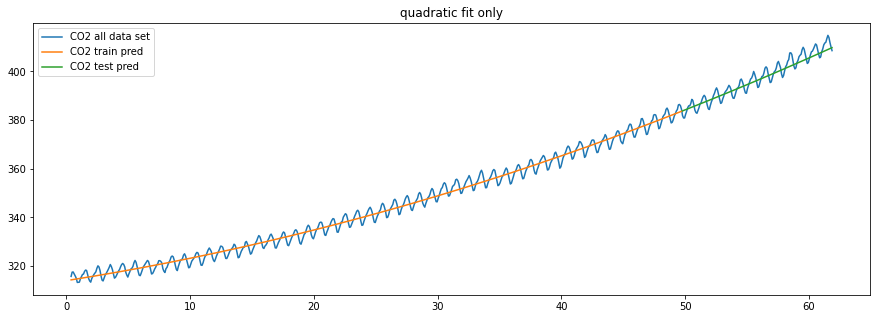

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(merged_df[['t']], merged_df.CO2, label="CO2 all data set")
plt.plot(merged_df[merged_df['type'] == "train"].t, merged_df[merged_df['type'] == "train"].CO2_pred, label="CO2 train pred")
plt.plot(merged_df[merged_df['type'] == "test"].t, merged_df[merged_df['type'] == "test"].CO2_pred, label="CO2 test pred")
plt.legend()
plt.title("quadratic fit only")
plt.show()

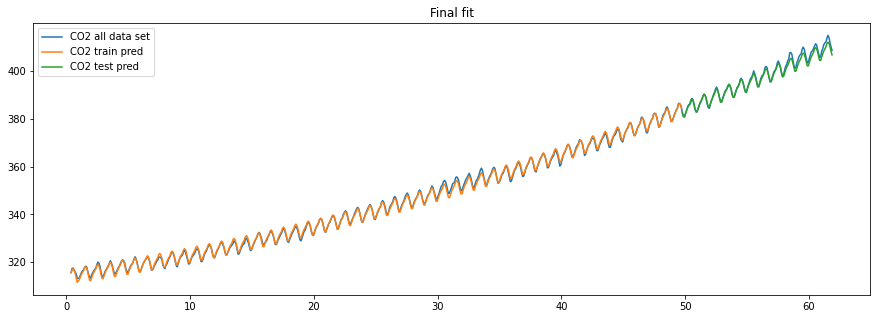

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(merged_df[['t']], merged_df.CO2, label="CO2 all data set")
plt.plot(merged_df[merged_df['type'] == "train"].t, merged_df[merged_df['type'] == "train"].final_fit, label="CO2 train pred")
plt.plot(merged_df[merged_df['type'] == "test"].t, merged_df[merged_df['type'] == "test"].final_fit, label="CO2 test pred")
plt.legend()
plt.title("Final fit")
plt.show()

In [ ]:
print("RMSE: {}".format(mean_squared_error(merged_df[merged_df['type'] == "test"].CO2, merged_df[merged_df['type'] == "test"].final_fit, squared=False)))
print("MAPE: {}".format(mean_absolute_percentage_error(merged_df[merged_df['type'] == "test"].CO2, merged_df[merged_df['type'] == "test"].final_fit)*100))

RMSE: 1.1385017014361456
MAPE: 0.20719330410998646


In [ ]:
max_val = max(merged_df.CO2_pred)
min_val = min(merged_df.CO2_pred)
range_pred = max_val - min_val
print("F (CO2_pred) = max: {}, min {}, range: {}".format(max_val, min_val, range_pred))

max_val = max(merged_df.CO2_dtrend_avg)
min_val = min(merged_df.CO2_dtrend_avg)
amplitud_pi = abs(max_val - min_val)/2

print("Pi (CO2_dtrend_avg) = max: {}, min {}, amplitud: {}".format(max_val, min_val, amplitud_pi))

max_val = max(merged_df.quadratic_residuals_without_Pi)
min_val = min(merged_df.quadratic_residuals_without_Pi)
range_qr = max_val - min_val

print("Ri (quadratic_residuals_without_Pi) = max: {}, min {}, range: {}".format(max_val, min_val, range_qr))

print()
print("Ratio range_F/amplitud_Pi = {}".format(range_pred/amplitud_pi))
print("Ratio amplitud_Pi/range_F = {}".format(amplitud_pi/range_pred))
print("Ratio amplitud_Pi/range_Ri = {}".format(amplitud_pi/range_qr))

F (CO2_pred) = max: 409.7676592766418, min 314.27265404575314, range: 95.49500523088864
Pi (CO2_dtrend_avg) = max: 2.981335251839811, min -3.3108615787136877, amplitud: 3.1460984152767493
Ri (quadratic_residuals_without_Pi) = max: 2.955615723190952, min -1.7417010546004352, range: 4.697316777791388

Ratio range_F/amplitud_Pi = 30.353470434105393
Ratio amplitud_Pi/range_F = 0.03294516197648333
Ratio amplitud_Pi/range_Ri = 0.6697650092817459


## CPI and BER Data Analysis

In [ ]:
import datetime

In [ ]:
df_cpi = pd.read_csv("CPI.csv")

# Convert to datetime
df_cpi['date'] = pd.to_datetime(df_cpi['date'])
df_cpi.set_index('date', inplace=True)

# group by year-month and sum the values
df_cpi = df_cpi.groupby(pd.Grouper(freq='M')).first()

# get t column
df_cpi['t'] = range(len(df_cpi))

# Drop nan
df_cpi.dropna(inplace=True)
df_cpi.head()

,CPI,t
date,,
2008-07-31,100.00000,0
2008-08-31,100.52510,1
2008-09-30,100.12380,2
2008-10-31,99.98538,3
2008-11-30,98.97539,4


In [ ]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 2008-07-31 to 2019-10-31
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     136 non-null    float64
 1   t       136 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 3.2 KB


In [ ]:
X = df_cpi[["t"]]
y = df_cpi.CPI

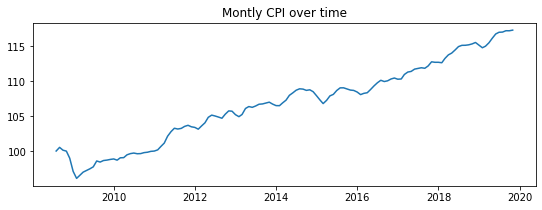

In [ ]:
plt.figure(figsize=(9, 3))
plt.plot(df_cpi.index, y)
plt.title("Montly CPI over time")
plt.show()

In [ ]:
# train_test_split = math.ceil(len(y) * 0.8)
# y_train, y_test = [:train_test_split], y[train_test_split:]
# X_train, X_test = X[:train_test_split], X[train_test_split:]
# assert(len(X_train) + len(X_test) == len(X))

In [ ]:
limit_date = "2013-09-1"
y_train, y_test = y[df_cpi.index < limit_date], y[df_cpi.index >= limit_date]
X_train, X_test = X[df_cpi.index < limit_date], X[df_cpi.index >= limit_date]
assert(len(X_train) + len(X_test) == len(X))

In [ ]:
len(X_train)

62

Intercept (B0): 96.72932632872502
Weight (B1): 0.16104348366951224
RMSE: 1.8007900862687192
MAPE: 1.435202517195968


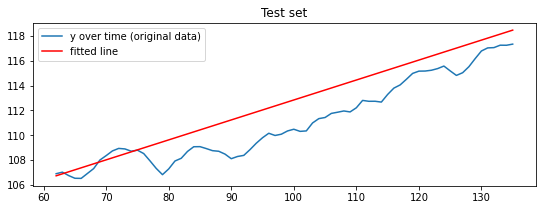

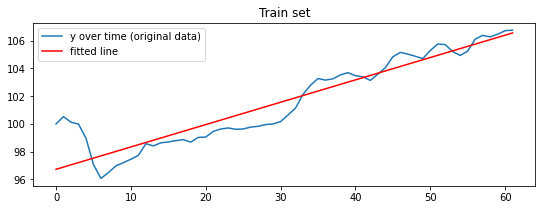

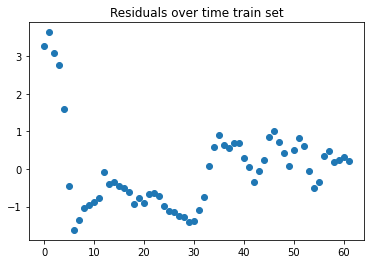

AIC: 191.067426525532
BIC: 193.19456091057708


In [ ]:
model, linear_residuals = fit_poly_linear_regression(X_train, y_train, X_test, y_test, 1)

In [ ]:
max(abs(linear_residuals))

3.634730187605456

Intercept (B0): 97.89172650393623
Weight (B1): 0.04480346614839111
Weight (B2): 0.0019055740577232992
RMSE: 12.112236426784671
MAPE: 9.405730807937172


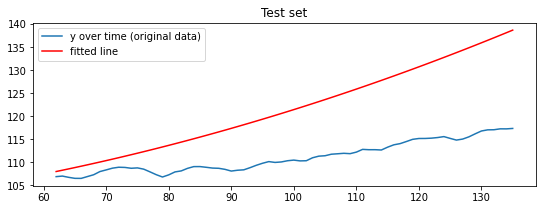

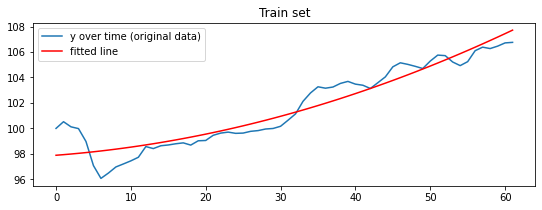

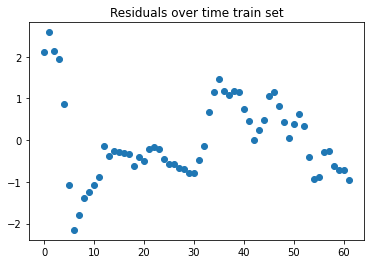

AIC: 175.97668838807743
BIC: 180.23095715816763


In [ ]:
_, _ = fit_poly_linear_regression(X_train, y_train, X_test, y_test, 2)

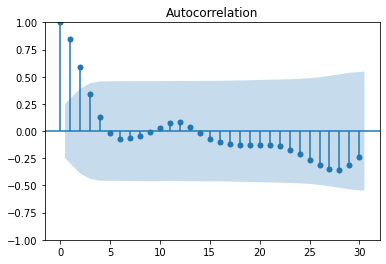

C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


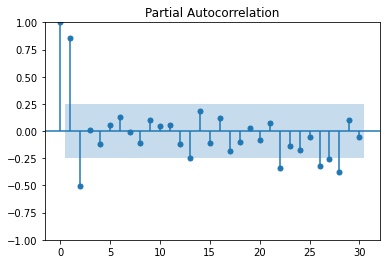

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(linear_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=30)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                   62
Model:                     AutoReg(2)   Log Likelihood                 -17.470
Method:               Conditional MLE   S.D. of innovations              0.324
Date:                Tue, 18 Apr 2023   AIC                             42.939
Time:                        18:28:41   BIC                             51.317
Sample:                    09-30-2008   HQIC                            46.216
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0431      0.042     -1.024      0.306      -0.126       0.039
CPI.L1         1.3237      0.098     13.461      0.000       1.131       1.516
CPI.L2        -0.5308      0.091     -5.824      0.0

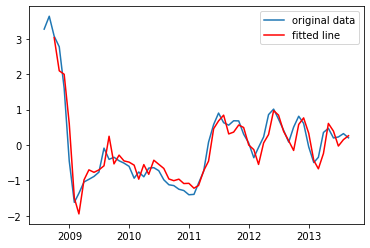

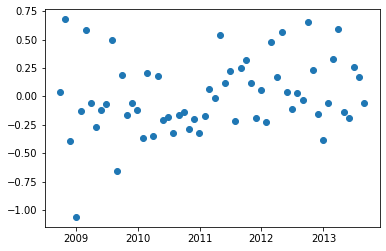

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

AR_order = 2
#ar_higher = ARIMA(linear_residuals, order=(AR_order, 0, 0)).fit()
ar_higher = AutoReg(linear_residuals, AR_order).fit()
print(ar_higher.summary())

ar_higher_predictions = ar_higher.predict()
ar_higher_residuals = linear_residuals - ar_higher_predictions
ar_higher_residuals = ar_higher_residuals # Fitting AR 1 model means removing one observation
plt.plot(linear_residuals, label='original data')
plt.plot(ar_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()

# Predict

In [ ]:
df_test = df_cpi.copy()
df_test["linear_reg"] = model.predict(df_test[['t']])
df_test["residual"] = df_test["CPI"] - df_test["linear_reg"]
df_test["AR"] = -0.0431 + 1.3237*df_test["residual"].shift(1) - 0.5308*df_test["residual"].shift(2)
df_forecast = df_test[df_test.index >= "2013-09-30"]
df_forecast["Pred"] = df_test["AR"] + df_forecast["linear_reg"]
df_forecast.head()

C:\Users\LuisGonzalez\AppData\Local\Temp\ipykernel_34056\228097780.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecast["Pred"] = df_test["AR"] + df_forecast["linear_reg"]


,CPI,t,linear_reg,residual,AR,Pred
date,,,,,,
2013-09-30,106.8835,62,106.714022,0.169478,0.054027,106.768049
2013-10-31,107.0078,63,106.875066,0.132734,0.073952,106.949017
2013-11-30,106.7322,64,107.036109,-0.303909,0.042642,107.078751
2013-12-31,106.5142,65,107.197153,-0.682953,-0.515840,106.681313
2014-01-31,106.5051,66,107.358196,-0.853096,-0.785810,106.572387


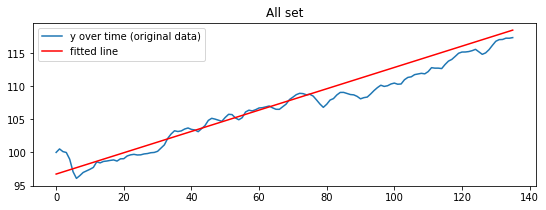

In [ ]:
fig = plt.figure(figsize=(9, 3))
plt.plot(df_test[['t']], df_test["CPI"], label='y over time (original data)')
plt.plot(df_test[['t']], df_test["linear_reg"], 'r', label='fitted line')
plt.legend()
plt.title("All set")
plt.show()

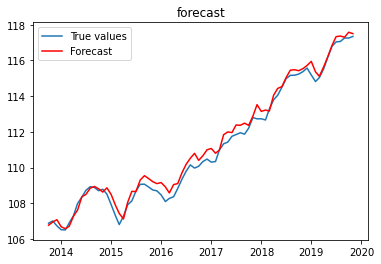

In [ ]:
# Prediction
plt.plot(df_forecast.index, df_forecast.CPI, label='True values')
plt.plot(df_forecast.index, df_forecast.Pred, 'r', label='Forecast')
plt.title("forecast")
plt.legend()
plt.show()

In [ ]:
print("RMSE: {}".format(mean_squared_error(df_forecast.CPI, df_forecast.Pred, squared=False)))

RMSE: 0.39100025178623227


### df_cpi 5. Converting to Inflation Rates

In [ ]:
df_IRt = df_cpi.copy()

In [ ]:
df_IRt.head()

,CPI,t
date,,
2008-07-31,100.00000,0
2008-08-31,100.52510,1
2008-09-30,100.12380,2
2008-10-31,99.98538,3
2008-11-30,98.97539,4


In [ ]:
df_IRt["diff"] = (y - y.shift(1))/y.shift(1)*100
df_IRt["diff_ln"] = (np.log(y) - np.log(y.shift(1)))*100
df_IRt.head()

,CPI,t,diff,diff_ln
date,,,,
2008-07-31,100.00000,0,NaN,NaN
2008-08-31,100.52510,1,0.525100,0.523726
2008-09-30,100.12380,2,-0.399204,-0.400003
2008-10-31,99.98538,3,-0.138249,-0.138344
2008-11-30,98.97539,4,-1.010138,-1.015274


In [ ]:
df_IRt.dropna(inplace=True)
len(df_IRt)

135

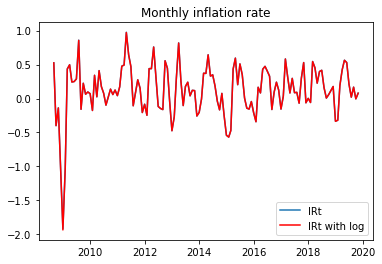

In [ ]:
plt.plot(df_IRt[["diff"]], label="IRt")
plt.plot(df_IRt[["diff_ln"]], 'r', label="IRt with log")
plt.title("Monthly inflation rate")
plt.legend()
plt.show()

In [ ]:
df_IRt[(df_IRt.index == "2013-02-28") | (df_IRt.index == "2013-01-31")]

,CPI,t,diff,diff_ln
date,,,,
2013-01-31,104.9293,54,-0.269264,-0.269627
2013-02-28,105.2396,55,0.295723,0.295287


#### Outliers

In [ ]:
def detect_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    return np.abs(z_scores) > threshold

In [ ]:
outliers_label = detect_outliers_z_score(df_IRt.diff_ln)
outliers_label[:6]

array([False, False, False,  True,  True,  True])

In [ ]:
trimmed_mean = np.mean(df_IRt.diff_ln[~outliers_label])

In [ ]:
df_IRt.diff_ln = np.where(outliers_label, trimmed_mean, df_IRt.diff_ln)

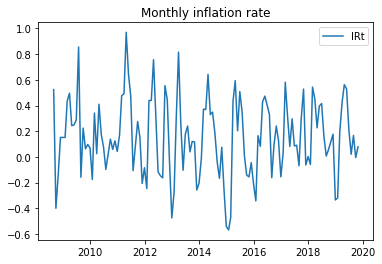

In [ ]:
plt.plot(df_IRt[["diff_ln"]], label="IRt")
plt.title("Monthly inflation rate")
plt.legend()
plt.show()

#### Split

In [ ]:
X = df_IRt[["t"]]
y = df_IRt.diff_ln

limit_date = "2013-09-1"
y_train, y_test = y[df_IRt.index < limit_date], y[df_IRt.index >= limit_date]
X_train, X_test = X[df_IRt.index < limit_date], X[df_IRt.index >= limit_date]
assert(len(X_train) + len(X_test) == len(X))

In [ ]:
X_train.head()

,t
date,
2008-08-31,1
2008-09-30,2
2008-10-31,3
2008-11-30,4
2008-12-31,5


Intercept (B0): 0.19789036138550314
Weight (B1): -0.0005773312405061398
RMSE: 0.2827570341091804
MAPE: 291.4802770510253


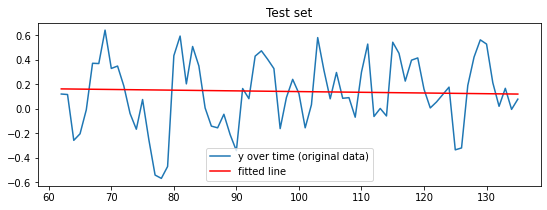

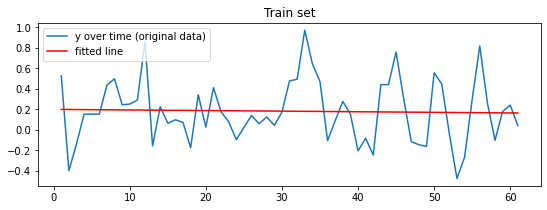

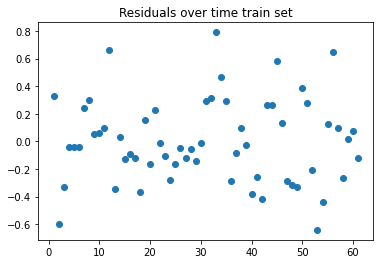

AIC: 28.833895650435252
BIC: 30.944769514608563


In [ ]:
model, linear_residuals = fit_poly_linear_regression(X_train, y_train, X_test, y_test, 1)

#### ACF and PACF

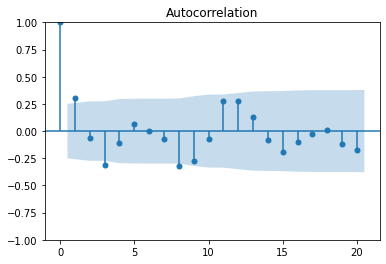

C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


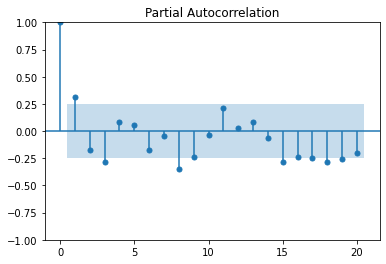

In [ ]:
sm.graphics.tsa.plot_acf(y_train, lags=20)
plt.show()
sm.graphics.tsa.plot_pacf(y_train, lags=20)
plt.show()

#### Fit a AR model

                            AutoReg Model Results                             
Dep. Variable:                diff_ln   No. Observations:                   61
Model:                     AutoReg(1)   Log Likelihood                 -10.037
Method:               Conditional MLE   S.D. of innovations              0.286
Date:                Tue, 18 Apr 2023   AIC                             26.074
Time:                        18:28:43   BIC                             32.357
Sample:                    09-30-2008   HQIC                            28.532
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1182      0.043      2.745      0.006       0.034       0.203
diff_ln.L1     0.3073      0.122      2.527      0.012       0.069       0.546
                                    Roots           

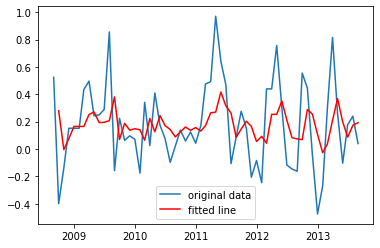

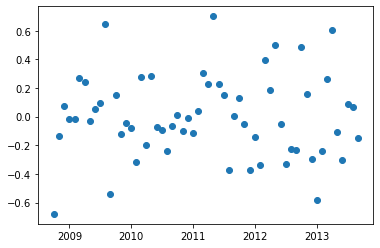

In [ ]:
AR_order = 1
ar_higher = AutoReg(y_train, AR_order).fit()
print(ar_higher.summary())

ar_higher_predictions = ar_higher.predict()
ar_higher_residuals = y_train - ar_higher_predictions
plt.plot(y_train, label='original data')
plt.plot(ar_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                diff_ln   No. Observations:                   61
Model:                     AutoReg(2)   Log Likelihood                  -6.163
Method:               Conditional MLE   S.D. of innovations              0.269
Date:                Tue, 18 Apr 2023   AIC                             20.325
Time:                        18:28:43   BIC                             28.635
Sample:                    10-31-2008   HQIC                            23.569
                         - 08-31-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1454      0.043      3.366      0.001       0.061       0.230
diff_ln.L1     0.4095      0.122      3.370      0.001       0.171       0.648
diff_ln.L2    -0.1859      0.120     -1.546      0.1

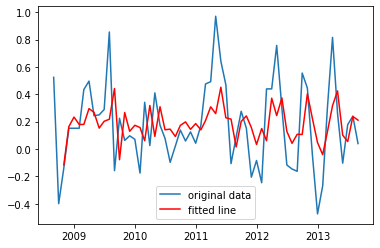

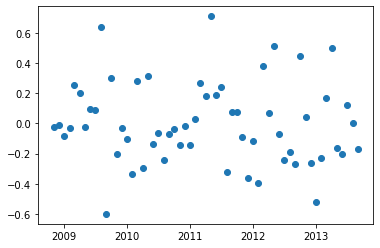

In [ ]:
AR_order = 2
ar_higher = AutoReg(y_train, AR_order).fit()
print(ar_higher.summary())

ar_higher_predictions = ar_higher.predict()
ar_higher_residuals = y_train - ar_higher_predictions
plt.plot(y_train, label='original data')
plt.plot(ar_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()

#### Predictions

In [ ]:
df_forecast = df_IRt.copy()
df_forecast["AR_pred"] = 0.1454 + 0.4095*df_forecast["diff_ln"].shift(1) - 0.1859*df_forecast["diff_ln"].shift(2)
df_forecast = df_forecast[df_forecast.index >= "2013-09-30"]
df_forecast.head()

,CPI,t,diff,diff_ln,AR_pred
date,,,,,
2013-09-30,106.8835,62,0.120275,0.120203,0.116989
2013-10-31,107.0078,63,0.116295,0.116227,0.187291
2013-11-30,106.7322,64,-0.257551,-0.257884,0.170649
2013-12-31,106.5142,65,-0.204250,-0.204458,0.018190
2014-01-31,106.5051,66,-0.008543,-0.008544,0.109615


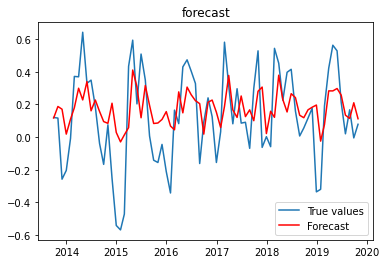

In [ ]:
# Prediction
plt.plot(df_forecast.index, df_forecast.diff_ln, label='True values')
plt.plot(df_forecast.index, df_forecast.AR_pred, 'r', label='Forecast')
plt.title("forecast")
plt.legend()
plt.show()

In [ ]:
def grid_search_AR(data, AR_range, verbose=False):
    min_aic = np.inf
    min_bic = np.inf
    min_rmse = np.inf
    min_aic_index = None
    min_bic_index = None
    min_rmse_index = None
    aic_matrix = np.zeros(len(AR_range))
    bic_matrix = np.zeros(len(AR_range))
    rmse_matrix = np.zeros(len(AR_range))
    for AR_order in AR_range:
        ar = AutoReg(data, AR_order).fit()

        aic_matrix[AR_order] = ar.aic
        bic_matrix[AR_order] = ar.bic
        if ar.aic < min_aic:
            min_aic = ar.aic
            min_aic_index = (AR_order)
        if ar.bic < min_bic:
            min_bic = ar.bic
            min_bic_index = (AR_order)

        prediction = ar.predict()
        rmse_metric = mean_squared_error(data[AR_order:], prediction.dropna(), squared=False)
        rmse_matrix[AR_order] = rmse_metric
        if rmse_metric < min_rmse:
            min_rmse = rmse_metric
            min_rmse_index = (AR_order)

    if verbose:
        print("Minimizing RMSE order: ", min_rmse_index)
        print("Minimizing AIC order: ", min_aic_index)
        print("Minimizing BIC order: ", min_bic_index )
        print("matrix of RMSE: {}".format(rmse_matrix))
        print("matrix of AIC", aic_matrix)
        print("Matrix of BIC", bic_matrix)
    return min_aic_index, min_bic_index, min_rmse_index, aic_matrix, bic_matrix, rmse_matrix

In [ ]:
_, _, _, _, _, rmse_matrix = grid_search_AR(df_IRt.diff_ln, range(8), verbose=True)

Minimizing RMSE order:  7
Minimizing AIC order:  3
Minimizing BIC order:  2
matrix of RMSE: [0.29135387 0.26262506 0.25108902 0.24906809 0.24967054 0.24954504
 0.24403769 0.24229423]
matrix of AIC [54.14489401 27.95205346 17.83954556 17.63212192 20.20726818 22.013898
 18.19453453 18.34203399]
Matrix of BIC [59.95544357 36.64557285 29.40094207 32.04613154 37.45845212 42.08663915
 41.07303376 44.01030637]


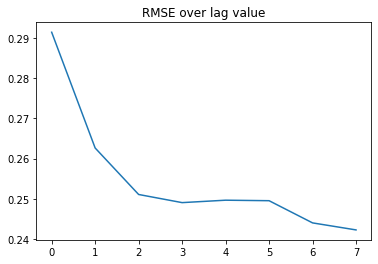

In [ ]:
plt.plot(range(8), rmse_matrix)
plt.title("RMSE over lag value")
plt.show()

### BER

In [ ]:
df_ber = pd.read_csv("T10YIE.csv")

# Convert to datetime
df_ber['DATE'] = pd.to_datetime(df_ber['DATE'])
df_ber.set_index('DATE', inplace=True)

# group by year-month and sum the values
df_ber = df_ber.groupby(pd.Grouper(freq='M')).mean()

# Convert percentage to decimal
df_ber['T10YIE'] = df_ber['T10YIE']/100

# get monthly BER, "T10YIE" is anual BER, result in percentage
df_ber['BER_M'] = ((df_ber['T10YIE'] + 1)**(1/12) - 1)*100

df_ber.head()

,T10YIE,BER_M
DATE,,
2003-01-31,0.017543,0.145028
2003-02-28,0.019126,0.158006
2003-03-31,0.018629,0.153928
2003-04-30,0.017748,0.146707
2003-05-31,0.016610,0.137370


In [ ]:
df_ber.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 203 entries, 2003-01-31 to 2019-11-30
Freq: M
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T10YIE  203 non-null    float64
 1   BER_M   203 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


In [ ]:
df_ber[(df_ber.index == "2013-02-28") | (df_ber.index == "2013-01-31")]

,T10YIE,BER_M
DATE,,
2013-01-31,0.025233,0.207884
2013-02-28,0.025547,0.210442


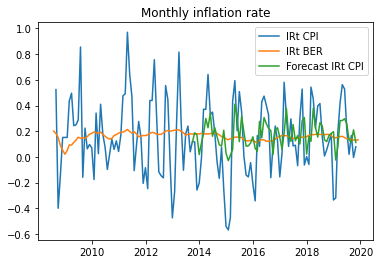

In [ ]:
plt.plot(df_IRt[["diff_ln"]], label="IRt CPI")
plt.plot(df_ber[df_ber.index >= "2008-07-31"][['BER_M']], label="IRt BER")
plt.plot(df_forecast[['AR_pred']], label='Forecast IRt CPI')
plt.title("Monthly inflation rate")
plt.legend()
plt.show()

# 6. External Regressors and Model Improvements (Written Report)

In [ ]:
limit_date = "2013-09-1"
# ber = df_ber[(df_ber.index > "2008-07-31") & (df_ber.index < "2019-11-30")]
ber = df_ber.copy()
ber = ber[(df_ber.index > "2008-07-31") & (ber.index <= limit_date)]
# ber = ber[ber.index <= limit_date]
cpi = df_IRt.copy()

X = cpi.index
y = cpi.diff_ln

cpi_train, cpi_test = cpi[cpi.index < limit_date], cpi[cpi.index >= limit_date]
X_train, X_test = X[cpi.index < limit_date], X[cpi.index >= limit_date]
assert(len(X_train) + len(X_test) == len(X))

print(len(ber))
print(len(cpi_train))

61
61


In [ ]:
ber.tail()

,T10YIE,BER_M
DATE,,
2013-04-30,0.024114,0.198760
2013-05-31,0.022832,0.188303
2013-06-30,0.020485,0.169126
2013-07-31,0.021223,0.175159
2013-08-31,0.021845,0.180248


In [ ]:
cpi_train.tail()

,CPI,t,diff,diff_ln
date,,,,
2013-04-30,106.3789,57,0.261448,0.261107
2013-05-31,106.2683,58,-0.103968,-0.104022
2013-06-30,106.4575,59,0.178040,0.177882
2013-07-31,106.7130,60,0.240002,0.239714
2013-08-31,106.7551,61,0.039452,0.039444


lag:  -1


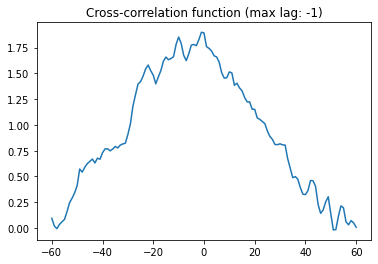

In [ ]:
from scipy import signal

# Compute the cross-correlation function
correlation = signal.correlate(cpi_train.diff_ln, ber.BER_M, mode="full")
lags = signal.correlation_lags(cpi_train.diff_ln.size, ber.BER_M.size, mode="full")
lag = lags[np.argmax(correlation)]
print("lag: ", lag)
plt.plot(lags, correlation)
plt.title("Cross-correlation function (max lag: -1)")
plt.show()

ber len:  61
cpi len:  61
                               SARIMAX Results                                
Dep. Variable:                diff_ln   No. Observations:                   61
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  -9.217
Date:                Tue, 18 Apr 2023   AIC                             26.434
Time:                        18:33:43   BIC                             34.877
Sample:                    08-31-2008   HQIC                            29.743
                         - 08-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
BER_M          1.0716      0.270      3.970      0.000       0.543       1.601
ar.L1          0.3963      0.130      3.050      0.002       0.142       0.651
ar.L2         -0.1913     

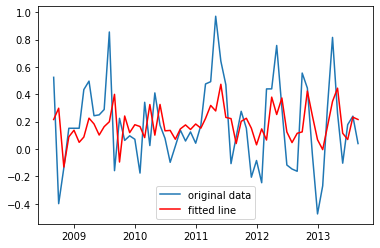

In [ ]:
import statsmodels.api as sm

# Create lagged exogenous variable
exog = df_ber.BER_M.shift(1)
exog = exog[(exog.index > "2008-07-31") & (exog.index < limit_date)]
print("ber len: ", len(exog))
print("cpi len: ", len(cpi_train.diff_ln))

# Create SARIMAX model
model = sm.tsa.SARIMAX(cpi_train.diff_ln, exog=exog, order=(2, 0, 0))

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

sarimax_higher_predictions = results.predict()
plt.plot(cpi_train.diff_ln, label='original data')
plt.plot(sarimax_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()

In [ ]:
# Predictions
df_forecast = df_IRt.copy()
ber = df_ber.copy()
ber['ber_lag1'] = ber.BER_M.shift(1)
ber = ber[(df_ber.index > "2008-07-31") & (df_ber.index < "2019-11-30")]
df_forecast["AR_pred"] = 0.3963*df_forecast["diff_ln"].shift(1) - 0.1913*df_forecast["diff_ln"].shift(2) + 1.0716*ber.ber_lag1 + 0.0790
df_forecast = df_forecast[df_forecast.index >= "2013-09-30"]
df_forecast.head()

,CPI,t,diff,diff_ln,AR_pred
date,,,,,
2013-09-30,106.8835,62,0.120275,0.120203,0.241928
2013-10-31,107.0078,63,0.116295,0.116227,0.308825
2013-11-30,106.7322,64,-0.257551,-0.257884,0.295458
2013-12-31,106.5142,65,-0.204250,-0.204458,0.146493
2014-01-31,106.5051,66,-0.008543,-0.008544,0.238603


In [ ]:
len(ber)

135

In [ ]:
len(df_forecast)

74

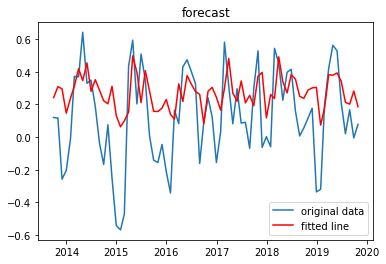

In [ ]:
plt.plot(cpi_test.diff_ln, label='original data')
plt.plot(df_forecast.AR_pred, 'r', label='fitted line')
plt.legend()
plt.title("forecast")
plt.show()

In [ ]:
print("RMSE: {}".format(mean_squared_error(df_forecast.diff_ln, df_forecast.AR_pred, squared=False)))

RMSE: 0.2771791370089299


In [ ]:
def grid_search_ARIMA(data, AR_range, MA_range, verbose=False):
    min_aic = np.inf
    min_bic = np.inf
    min_aic_index = None
    min_bic_index = None
    aic_matrix = np.zeros((len(AR_range), len(MA_range)))
    bic_matrix = np.zeros((len(AR_range), len(MA_range)))
    for AR_order in AR_range:
        for MA_order in MA_range:
            arma = ARIMA(data, order=(AR_order, 0, MA_order)).fit()
            aic_matrix[AR_order, MA_order] = arma.aic
            bic_matrix[AR_order, MA_order] = arma.bic
            if arma.aic < min_aic:
                min_aic = arma.aic
                min_aic_index = (AR_order, 0, MA_order)
            if arma.bic < min_bic:
                min_bic = arma.bic
                min_bic_index = (AR_order, 0, MA_order)
    if verbose:
        print("Minimizing AIC order: ", min_aic_index)
        print("Minimizing BIC order: ", min_bic_index )
        print("matrix of AIC", aic_matrix)
        print("Matrix of BIC", bic_matrix)

    return min_aic_index, min_bic_index, aic_matrix, bic_matrix

In [ ]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(cpi_train.diff_ln, range(4), range(4), verbose=True)

C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization faile

Minimizing AIC order:  (1, 0, 3)
Minimizing BIC order:  (0, 0, 3)
matrix of AIC [[30.90319407 26.32790564 26.541511   19.47580536]
 [26.84462669 28.06871988 25.98160233 17.84401271]
 [26.51506039 22.31428818 24.72845663 19.77159137]
 [23.80244326 25.36173146 24.02455548 24.7049056 ]]
Matrix of BIC [[35.1249418  32.66052723 34.98500645 30.03017468]
 [33.17724828 36.51221534 36.53597165 30.50925589]
 [34.95855584 32.8686575  37.39369981 34.54770842]
 [34.35681258 38.02697464 38.80067253 41.59189651]]


C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                diff_ln   No. Observations:                   61
Model:                 ARIMA(0, 0, 3)   Log Likelihood                  -4.738
Date:                Tue, 18 Apr 2023   AIC                             19.476
Time:                        21:06:03   BIC                             30.030
Sample:                    08-31-2008   HQIC                            23.612
                         - 08-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1821      0.034      5.434      0.000       0.116       0.248
ma.L1          0.3186      0.115      2.767      0.006       0.093       0.544
ma.L2          0.1760      0.126      1.395      0.1

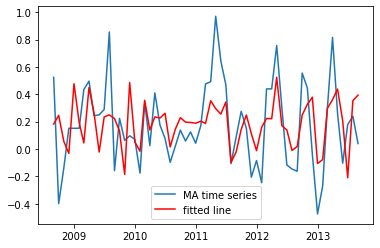

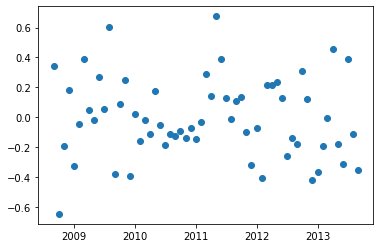

Automatic selection finds model with AR 0, MA 3
MSE with selected model: 0.06989855384114707


In [ ]:
arma = ARIMA(cpi_train.diff_ln, order=min_bic_index).fit()
print(arma.summary())
arma_predictions = arma.predict()
arma_residuals = cpi_train.diff_ln - arma_predictions
arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
plt.plot(cpi_train.diff_ln, label='MA time series')
plt.plot(arma_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(arma_residuals, 'o')
plt.show()
print("Automatic selection finds model with AR {0}, MA {2}".format(*min_bic_index))
print("MSE with selected model:", np.mean(arma_residuals**2))

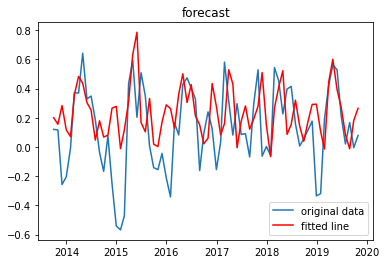

RMSE: 0.2888181229681028


In [ ]:
def predict_ma(ma_coeffs, data, const):
    # Initialize an empty list to store the predicted values
    predictions = []
    # Loop through the historical data
    for i in range(len(data)):
        # Calculate the predicted value using the moving average formula
        if i < len(ma_coeffs):
            prediction = sum([ma_coeffs[j] * data[i-j-1] for j in range(i+1)]) + const
        else:
            prediction = sum([ma_coeffs[j] * data[i-j-1] for j in range(len(ma_coeffs))]) + const
        # Append the predicted value to the list
        predictions.append(prediction)
    # Return the predicted values as a numpy array
    return np.array(predictions)

ma_coeffs = [0.3186, 0.1760, - 0.5768]

df_forecast = df_IRt.copy()

df_forecast["MA_pred"] = predict_ma(ma_coeffs, df_forecast['diff_ln'], 0.1821 + 0.0661)
df_forecast = df_forecast[df_forecast.index >= "2013-09-30"]

plt.plot(cpi_test.diff_ln, label='original data')
plt.plot(df_forecast.MA_pred, 'r', label='fitted line')
plt.legend()
plt.title("forecast")
plt.show()

print("RMSE: {}".format(mean_squared_error(df_forecast.diff_ln, df_forecast.MA_pred, squared=False)))

C:\Users\LuisGonzalez\Virtual envs\Jupiter\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                diff_ln   No. Observations:                   61
Model:                 ARIMA(1, 0, 3)   Log Likelihood                  -2.922
Date:                Tue, 18 Apr 2023   AIC                             17.844
Time:                        21:05:48   BIC                             30.509
Sample:                    08-31-2008   HQIC                            22.808
                         - 08-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1889      0.011     17.479      0.000       0.168       0.210
ar.L1          0.4580      0.168      2.733      0.006       0.130       0.787
ma.L1         -0.1544      2.163     -0.071      0.9

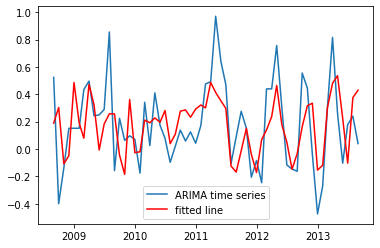

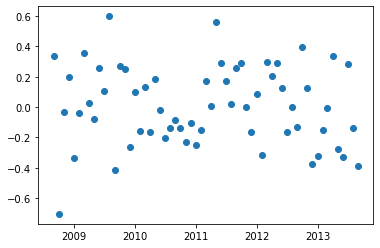

Automatic selection finds model with ARIMA 1, MA 3
MSE with selected model: 0.06644729429209104


In [ ]:
arma = ARIMA(cpi_train.diff_ln, order=min_aic_index).fit()
print(arma.summary())
arma_predictions = arma.predict()
arma_residuals = cpi_train.diff_ln - arma_predictions
arma_residuals = arma_residuals # Fitting AR 1 model means removing one observation
plt.plot(cpi_train.diff_ln, label='ARIMA time series')
plt.plot(arma_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(arma_residuals, 'o')
plt.show()
print("Automatic selection finds model with ARIMA {0}, MA {2}".format(*min_aic_index))
print("MSE with selected model:", np.mean(arma_residuals**2))

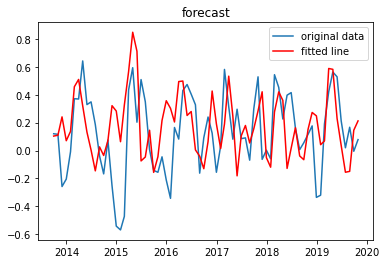

RMSE: 0.3139276061568122


In [ ]:
ma_coeffs = [-0.1544, -0.1275, -0.7147]

df_forecast = df_IRt.copy()

df_forecast["MA_pred"] = predict_ma(ma_coeffs, df_forecast['diff_ln'], 0.0605)
df_forecast["AR_pred"] = 0.1889 + 0.4580*df_forecast.diff_ln.shift(1)
df_forecast["final_pred"] = df_forecast["MA_pred"] + df_forecast["AR_pred"]

df_forecast = df_forecast[df_forecast.index >= "2013-09-30"]

plt.plot(cpi_test.diff_ln, label='original data')
plt.plot(df_forecast.final_pred, 'r', label='fitted line')
plt.legend()
plt.title("forecast")
plt.show()

print("RMSE: {}".format(mean_squared_error(df_forecast.diff_ln, df_forecast.final_pred, squared=False)))